### Tensorflow를 이용하여 Mask RCNN Inferece 수행. 

### 본 실습 예제는 GPU를 활용하므로 상단 메뉴에서 런타임->런타임 유형 변경에서 GPU를 선택해 주십시요. 

ensorflow, keras 설치 및 강의 실습코드/데이터 Download

Colab 버전은 colab에서 pip 명령어를 이용하여 tensorflow 1.13, keras 2.2를 소스코드 커널 기동시 마다 설치해야 합니다

Colab의 tensorflow는 2020년 기준으로 2.2 이며, keras는 2.3입니다. 실습코드는 tensorflow 1.13과 1.15, keras 2.2 기준으로 되어 있으므로 이를 downgrade해야 합니다.

pip를 이용하여 tensorflow 1.13을 설치하면 자동으로 downgrade 됩니다.

OpenCV는 Colab에서 이미 설치 되어 있으니 추가설치는 필요 없습니다.

강의 실습코드와 데이터는 https://github.com/chulminkw/DLCV.git 에서 다운로드 할 수 있습니다. 

In [1]:
# 현재 디렉토리는 /content이며 이 디렉토리를 기준으로 실습코드와 데이터를 다운로드 합니다. 
!pwd
!git clone https://github.com/chulminkw/DLCV.git
# DLCV 디렉토리가 Download되고 DLCV 밑에 Detection과 Segmentation 디렉토리가 있는 것을 확인
!ls -lia 
!ls -lia DLCV

# tensorflow 1.13을 설치합니다. 자동으로 tensorflow 2.2가 1.13으로 downgrade 됩니다. 
!pip install tensorflow-gpu==1.15.2 
# keras 2.2를 설치합니다. pip install keras==2.2.1 시 자동으로 2.3에서 2.2.1로 downgrade 됩니다. 
!pip install keras==2.3.0


/content
Cloning into 'DLCV'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 128.12 MiB | 45.32 MiB/s, done.
Resolving deltas: 100% (57/57), done.
total 20
1310745 drwxr-xr-x 1 root root 4096 Aug 11 10:04 .
2249441 drwxr-xr-x 1 root root 4096 Aug 11 10:03 ..
1310746 drwxr-xr-x 1 root root 4096 Aug  3 16:17 .config
3563578 drwxr-xr-x 6 root root 4096 Aug 11 10:04 DLCV
1179671 drwxr-xr-x 1 root root 4096 Jul 30 16:30 sample_data
total 820
3563578 drwxr-xr-x 6 root root   4096 Aug 11 10:04 .
1310745 drwxr-xr-x 1 root root   4096 Aug 11 10:04 ..
3563594 drwxr-xr-x 6 root root   4096 Aug 11 10:04 data
3563585 drwxr-xr-x 8 root root   4096 Aug 11 10:04 Detection
3560557 -rw-r--r-- 1 root root 807528 Aug 11 10:04 DLCV_Colab_SrcCode.zip
3563579 drwxr-xr-x 8 root root   4096 Aug 11 10:04 .git
3560577 -rw-r--r-- 1 root root    142 Aug 11 10:04 README.md
3563592 drwxr-xr-x 3 root root   4096 Aug 11 10:0

In [2]:
# tensorflow는 1.13, keras는 2.2 버전 확인
# GPU가 세팅되어 있지 않으면 상단 메뉴에서 런타임->런타임 유형 변경에서 GPU를 선택한 후 런타임 다시 시작을 선택하고 처음 부터인 tensorflow, keras 설치 부터 다시 시작. 
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

# gpu가 세팅되어 있는지 확인. 
tf.test.gpu_device_name()

Using TensorFlow backend.


1.15.2
2.3.0


'/device:GPU:0'

#### Tensorflow에서 Pretrained 된 Inference모델(Frozen graph)을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성
* https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음.
* pretrained 모델은 http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz 에서 다운로드 후 압축 해제 후 이를 이용해 inferece 수행. 

In [3]:
#코랩 버전은 OS 터미널이 아닌 코랩 Cell 에서 os command를 수행해야 합니다. 
#아래 command는 코랩에서 OS 명령어를 통해 mask_rcnn/pretrained 디렉토리를 만듭니다. 

!rm -rf /content/DLCV/Segmentation/mask_rcnn/pretrained
!mkdir /content/DLCV/Segmentation/mask_rcnn/pretrained
# pretrained 디렉토리가 생성되었는지 확인 합니다. 
%cd /content/DLCV/Segmentation/mask_rcnn
!ls

### coco 데이터 세트로 pretrained 된 faster rcnn weight 파일과 config용 graph pbtxt 다운로드 
%cd /content/DLCV/Segmentation/mask_rcnn/pretrained
!echo "##### downloading pretrained weight file and config pbtxt file"
!wget http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
!wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt

# tar 파일 압축 해제
!echo "##### uncompressing tar file"
!tar -xvf mask_rcnn_inception_v2_coco_2018_01_28.tar.gz

# config용 pbtxt 파일의 이름을 graph.pbtxt로 변경
# echo "renaming pbtxt file name"
!mv /content/DLCV/Segmentation/mask_rcnn/pretrained/mask_rcnn*.pbtxt /content/DLCV/Segmentation/mask_rcnn/pretrained/mask_rcnn_inception_v2_coco_2018_01_28/graph.pbtxt

# tar 파일 삭제
!echo "##### deleting tar file" 
!rm *.gz

# weight파일과 config 파일이 있는 pretrained/mask_rcnn_inception_v2_coco_2018_01_28 디렉토리 내부 확인 
!echo "##### check out pretrained/mask_rcnn_inception_v2_coco_2018_01_28"
!ls /content/DLCV/Segmentation/mask_rcnn/pretrained/mask_rcnn_inception_v2_coco_2018_01_28

/content/DLCV/Segmentation/mask_rcnn
Balloon_데이터세트_학습및_Segmentation.ipynb
Kaggle_Nucleus_Segmentation_Challenge.ipynb
Matterport패키지를_이용한_Segmentation.ipynb
OpenCV를_이용한_Mask_RCNN_Segmentation.ipynb
pretrained
Tensorflow를_이용한_Mask_RCNN_Segmentation.ipynb
/content/DLCV/Segmentation/mask_rcnn/pretrained
##### downloading pretrained weight file and config pbtxt file
--2020-08-11 10:09:22--  http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177817887 (170M) [application/x-tar]
Saving to: ‘mask_rcnn_inception_v2_coco_2018_01_28.tar.gz’

mask_rcnn_inception 100%[===================>] 169.58M   107MB/s    in 1.6s    

2020-08-11 10:09:25 (107 MB/s) - ‘mask_rcnn_inception_v2_coco_2018_01_28.tar.g

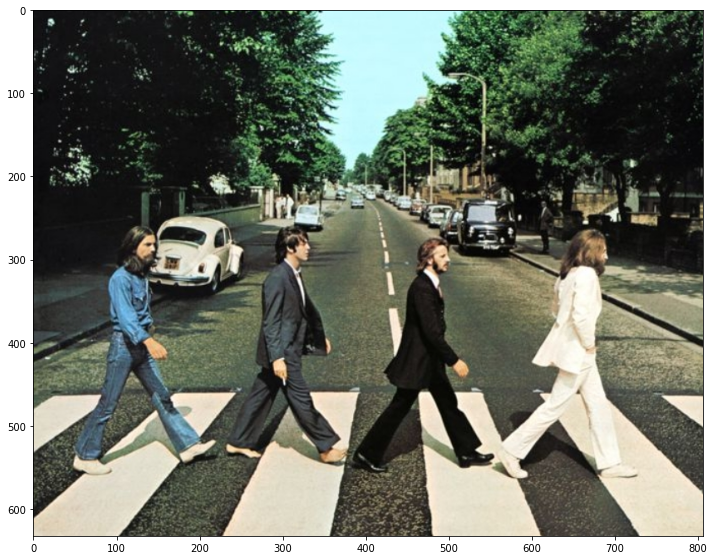

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy  as np
import os
%matplotlib inline

default_dir = '/content/DLCV'
beatles_img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))
beatles_img_rgb = cv2.cvtColor(beatles_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(beatles_img_rgb)


In [5]:
# Tensorflow의 Object Detection 모델 Weight인 frozen_inference_graph를 이용하여 mask rcnn inference 수행. 

In [6]:
# coco dataset의 클래스 ID별 클래스명 매핑
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}


#masking 시 클래스별 컬러 적용
colors = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250],
     [50, 190, 190]] )

Instructions for updating:
Use tf.gfile.GFile.
### out 크기와 타입: 5 <class 'list'>
(1,) (1, 100) (1, 100, 4) (1, 100) (1, 100, 15, 15)
num_detection: [19.] score by objects: [0.99904734 0.9989041  0.9975172  0.996427   0.91794276 0.91776633
 0.8678005  0.8644332  0.7517814  0.6937805  0.55412984 0.5083715
 0.4498845  0.4359219  0.3993884  0.3890986  0.3505336  0.33244354
 0.3084407  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.   

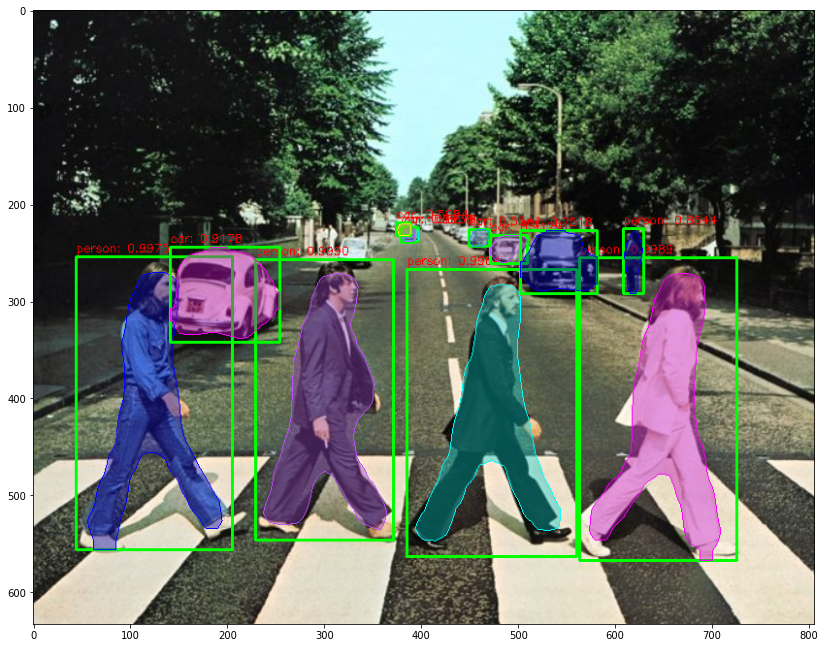

In [7]:
import numpy as np
import tensorflow as tf
import cv2
import time
import matplotlib.pyplot as plt
%matplotlib inline


#코랩 버전은 default_mask_dir 절대 경로를 이용합니다. os.path.join()으로 상세 파일/디렉토리를 지정합니다. 
default_mask_dir='/content/DLCV/Segmentation/mask_rcnn'

#inference graph를 읽음. .
with tf.gfile.FastGFile(os.path.join(default_mask_dir, 'pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    
with tf.Session() as sess:
    # Session 시작하고 inference graph 모델 로딩 
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    
    # 입력 이미지 생성 및 BGR을 RGB로 변경 
    default_dir = '/content/DLCV'
    img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))
    draw_img = img.copy()
    
    img_height = img.shape[0]
    img_width = img.shape[1]
    #inp = cv2.resize(img, (300, 300))
    # OpenCV로 입력받은 BGR 이미지를 RGB 이미지로 변환 
    inp = img[:, :, [2, 1, 0]] 

    start = time.time()
    # Object Detection 수행 및 mask 정보 추출. 'detection_masks:0' 에서 mask결과 추출 
    out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                    sess.graph.get_tensor_by_name('detection_scores:0'),
                    sess.graph.get_tensor_by_name('detection_boxes:0'),
                    sess.graph.get_tensor_by_name('detection_classes:0'),
                    sess.graph.get_tensor_by_name('detection_masks:0')],
                   feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})
    
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    score_threshold = 0.5
    mask_threshold = 0.4
    
    #### out 결과, 타입 Debugging #### 
    print("### out 크기와 타입:", len(out), type(out))
    print(out[0].shape, out[1].shape, out[2].shape, out[3].shape, out[4].shape)
    print('num_detection:',out[0], 'score by objects:', out[1][0], 'bounding box')
    # Bounding Box 시각화 
    # Detect된 Object 별로 bounding box 시각화 
    num_detections = int(out[0][0])
    for i in range(num_detections):
        # Object별 class id와 object class score, bounding box정보를 추출
        classId = int(out[3][0][i])
        score = float(out[1][0][i])
        bbox = [float(v) for v in out[2][0][i]]
        # Object별 mask 정보 추출
        classMask = out[4][0][i]
        
        if score > score_threshold:
            left = int(bbox[1] * img_width)
            top = int(bbox[0] * img_height)
            right = int(bbox[3] * img_width)
            bottom = int(bbox[2] * img_height)
            # cv2의 rectangle(), putText()로 bounding box의 클래스명 시각화 
            cv2.rectangle(draw_img, (left, top), (right,bottom ), green_color, thickness=2)
            caption = "{}: {:.4f}".format(labels_to_names[classId], score)
            print(caption)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
            
            # 원본 이미지의 object 크기에 맞춰 mask 크기 scale out 
            scaled_classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
            print('원본 이미지 비율로 scale out된 classMask shape:', scaled_classMask.shape)
            # 지정된 mask Threshold 값 이상인지 True, False boolean형태의 mask 정보 생성. 
            s_mask_b = (scaled_classMask > mask_threshold)
            print('scaled mask shape:', s_mask_b.shape, 'scaled mask pixel count:', s_mask_b.shape[0]*s_mask_b.shape[1],
                  'scaled mask true shape:',s_mask_b[s_mask_b==True].shape, 
                  'scaled mask False shape:', s_mask_b[s_mask_b==False].shape)
            # mask를 적용할 bounding box 영역의 image 추출
            before_mask_roi = draw_img[top:bottom+1, left:right+1]
            print('before_mask_roi:', before_mask_roi.shape)
            
            # Detect된 Object에 mask를 특정 투명 컬러로 적용. 
            colorIndex = np.random.randint(0, len(colors)-1)
            color = colors[colorIndex]
            after_mask_roi = draw_img[top:bottom+1, left:right+1][s_mask_b]
            draw_img[top:bottom+1, left:right+1][s_mask_b] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * after_mask_roi).astype(np.uint8)
            # Detect된 Object에 윤곽선(contour) 적용. 
            s_mask_i = s_mask_b.astype(np.uint8)
            contours, hierarchy = cv2.findContours(s_mask_i,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(draw_img[top:bottom+1, left:right+1], contours, -1, color, 1, cv2.LINE_8, hierarchy, 100)

plt.figure(figsize=(14, 14))
img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [8]:
## 이전 opencv에서 선언한 get_box_info()함수에 left, top, right, bottom을 가지오는 bbox 위치 인덱스 변경
def get_box_info(bbox, img_width, img_height):
    
    left = int(bbox[1] * img_width)
    top = int(bbox[0] * img_height)
    right = int(bbox[3] * img_width)
    bottom = int(bbox[2] * img_height)
    
    left = max(0, min(left, img_width - 1))
    top = max(0, min(top, img_height - 1))
    right = max(0, min(right, img_width - 1))
    bottom = max(0, min(bottom, img_height - 1))
    
    return left, top, right, bottom

# 이전 opencv에서 선언한 draw_box()함수에 classId, score 인자가 추가됨.     
def draw_box(img_array, classId, score, box, img_width, img_height, is_print=False):
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    
    left, top, right, bottom = get_box_info(box, img_width, img_height)
    text = "{}: {:.4f}".format(labels_to_names[classId], score)
    
    if is_print:
        pass
        #print("box:", box, "score:", score, "classId:", classId)
    
    cv2.rectangle(img_array, (left, top), (right, bottom), green_color, thickness=2 )
    cv2.putText(img_array, text, (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, thickness=1)
    
    return img_array
    
def draw_mask(img_array, bbox, classMask, img_width, img_height, mask_threshold, is_print=False):
        
        left, top, right, bottom = get_box_info(bbox, img_width, img_height)
        # 원본 이미지의 object 크기에 맞춰 mask 크기 scale out 
        scaled_classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
        s_mask_b = (scaled_classMask > mask_threshold)
        before_mask_roi = img_array[top:bottom+1, left:right+1]
        
        # mask를 적용할 bounding box 영역의 image 추출하고 투명 color 적용. 
        colorIndex = np.random.randint(0, len(colors)-1)
        #color = colors[colorIndex]
        color=(224, 32, 180)
        after_mask_roi = img_array[top:bottom+1, left:right+1][s_mask_b]
        img_array[top:bottom+1, left:right+1][s_mask_b] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * after_mask_roi).astype(np.uint8)
        # Detect된 Object에 윤곽선(contour) 적용. 
        s_mask_i = s_mask_b.astype(np.uint8)
        contours, hierarchy = cv2.findContours(s_mask_i,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img_array[top:bottom+1, left:right+1], contours, -1, color, 1, cv2.LINE_8, hierarchy, 100)
        
        return img_array

In [9]:
import time

def detect_image_mask_rcnn_tensor(sess, img_array, conf_threshold, mask_threshold, use_copied_array, is_print=False):
    
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
        #draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    else:
        draw_img = img_array
    
    img_height = img_array.shape[0]
    img_width = img_array.shape[1]
    
    # BGR을 RGB로 변환하여 INPUT IMAGE 입력 준비
    inp = img_array[:, :, [2, 1, 0]]  

    start = time.time()
    # Object Detection 수행 및 mask 정보 추출. 'detection_masks:0' 에서 mask결과 추출 
    out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                    sess.graph.get_tensor_by_name('detection_scores:0'),
                    sess.graph.get_tensor_by_name('detection_boxes:0'),
                    sess.graph.get_tensor_by_name('detection_classes:0'),
                    sess.graph.get_tensor_by_name('detection_masks:0')],
                   feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})
    if is_print:
        print('Segmentation Inference time {0:}'.format(round(time.time() - start, 4)))
        
    num_detections = int(out[0][0])

    for i in range(num_detections):
        # Object별 class id와 object class score, bounding box정보를 추출
        classId = int(out[3][0][i])
        score = float(out[1][0][i])
        bbox = [float(v) for v in out[2][0][i]]
        # Object별 mask 정보 추출
        classMask = out[4][0][i]

        if score > conf_threshold:
            draw_box(img_array , classId, score, bbox, img_width, img_height, is_print=is_print)
            draw_mask(img_array, bbox, classMask, img_width, img_height, mask_threshold, is_print=is_print)
    
    return img_array

Segmentation Inference time 4.2969


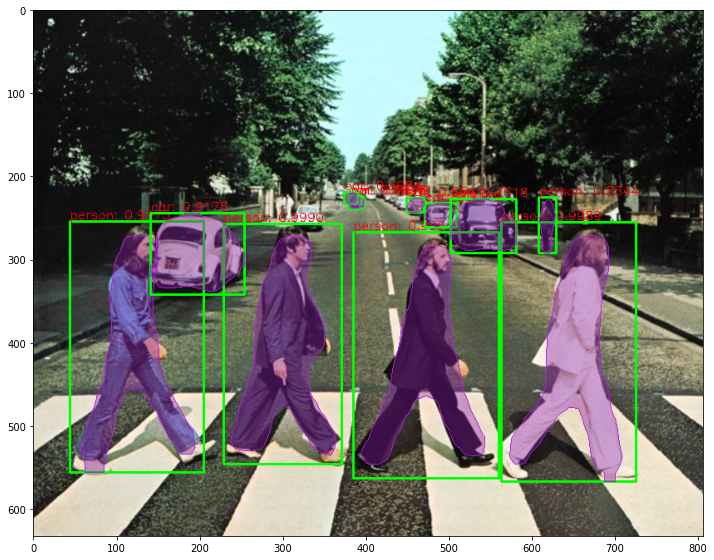

In [10]:
#inference graph를 읽음. 
#코랩 버전은 default_mask_dir 절대 경로를 이용합니다. os.path.join()으로 상세 파일/디렉토리를 지정합니다. 
default_mask_dir='/content/DLCV/Segmentation/mask_rcnn'
with tf.gfile.FastGFile(os.path.join(default_mask_dir, 'pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    
with tf.Session() as sess:
    # Session 시작하고 inference graph 모델 로딩 
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    
    # 입력 이미지 생성, Object Detection된 image 반환, 반환된 image의 BGR을 RGB로 변경
    default_dir = '/content/DLCV' 
    img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))
    draw_img = detect_image_mask_rcnn_tensor(sess, img, conf_threshold=0.5, mask_threshold=0.4, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

In [11]:
#inference graph를 읽음. 
default_mask_dir='/content/DLCV/Segmentation/mask_rcnn'
f = tf.gfile.FastGFile(os.path.join(default_mask_dir, 'pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'), 'rb')
graph_def = tf.GraphDef()
graph_def.ParseFromString(f.read())

sess = tf.Session()
sess.graph.as_default()
tf.import_graph_def(graph_def, name='')

In [12]:
default_dir = '/content/DLCV' 
img = cv2.imread(os.path.join(default_dir, 'data/image/john_wick01.jpg'))
draw_img = detect_image_mask_rcnn_tensor(sess, img, conf_threshold=0.5, mask_threshold=0.4, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

Segmentation Inference time 6.5226


In [ ]:
#### 이번에는 다른 이미지 파일을 이용.

In [13]:
img = cv2.imread(os.path.join(default_dir, 'data/image/beatles03.jpg'))
draw_img = detect_image_mask_rcnn_tensor(sess, img, conf_threshold=0.5, mask_threshold=0.4, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 16))
plt.imshow(img_rgb)

Segmentation Inference time 1.8994


#### Video Segmentation 적용

In [ ]:
# 코랩 버전은 아래 코드를 이용합니다.
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/DLCV/data/video/London_Street.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [14]:
video_input_path = os.path.join(default_dir, 'data/video/London_Street.mp4')
# linux에서 video output의 확장자는 반드시 avi 로 설정 필요. 
video_output_path = os.path.join(default_dir, 'data/output/London_Street_mask_rcnn_01.avi')

cap = cv2.VideoCapture(video_input_path)

codec = cv2.VideoWriter_fourcc(*'XVID')

vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
vid_fps = cap.get(cv2.CAP_PROP_FPS)
    
vid_writer = cv2.VideoWriter(video_output_path, codec, vid_fps, vid_size) 

frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('총 Frame 갯수:', frame_cnt, 'FPS:', vid_fps )

frame_index = 0
while True:
    hasFrame, img_frame = cap.read()
    if not hasFrame:
        print('더 이상 처리할 frame이 없습니다.')
        break
    frame_index += 1
    print("frame index:{0:}".format(frame_index), end=" ")
    draw_img_frame = detect_image_mask_rcnn_tensor(sess, img_frame, conf_threshold=0.5, mask_threshold=0.4, use_copied_array=False, is_print=True)
    vid_writer.write(draw_img_frame)
# end of while loop

vid_writer.release()
cap.release()  


총 Frame 갯수: 489 FPS: 29.636423507926278
frame index:1 Segmentation Inference time 0.7837
frame index:2 Segmentation Inference time 0.1102
frame index:3 Segmentation Inference time 0.1168
frame index:4 Segmentation Inference time 0.1148
frame index:5 Segmentation Inference time 0.113
frame index:6 Segmentation Inference time 0.1107
frame index:7 Segmentation Inference time 0.1257
frame index:8 Segmentation Inference time 0.1142
frame index:9 Segmentation Inference time 0.1151
frame index:10 Segmentation Inference time 0.1115
frame index:11 Segmentation Inference time 0.1169
frame index:12 Segmentation Inference time 0.1112
frame index:13 Segmentation Inference time 0.1138
frame index:14 Segmentation Inference time 0.1222
frame index:15 Segmentation Inference time 0.1178
frame index:16 Segmentation Inference time 0.1106
frame index:17 Segmentation Inference time 0.1285
frame index:18 Segmentation Inference time 0.1222
frame index:19 Segmentation Inference time 0.1256
frame index:20 Segme

In [ ]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 이를 위해 google drive를 colab에 mount 수행. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

In [ ]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 
## My Drive 디렉토리 이름에 공란이 있으므로 ' '로 묶습니다. 
!cp /content/DLCV/data/output/London_Street_mask_rcnn_01.avi '/content/gdrive/My Drive/London_Street_mask_rcnn_01.avi'